In [ ]:
pip install transformers torch sentencepiece

In [ ]:
import torch
from transformers import AutoTokenizer, pipeline
import numpy as np
import pandas as pd
from collections import Counter, defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List, Tuple, Dict
import re
from tqdm import tqdm
from functools import lru_cache
import warnings
warnings.filterwarnings('ignore')

print("✓ Libraries imported")

✓ Libraries imported


In [ ]:
from huggingface_hub import login
login()

In [ ]:
from datasets import load_dataset
dataset = load_dataset("Shelton1013/SwitchLingua_text")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/14.1k [00:00<?, ?B/s]

Arabic_eng.csv:   0%|          | 0.00/55.7M [00:00<?, ?B/s]

Can_Eng.csv:   0%|          | 0.00/694M [00:00<?, ?B/s]

Chinese_eng.csv:   0%|          | 0.00/56.7M [00:00<?, ?B/s]

French_eng.csv:   0%|          | 0.00/51.7M [00:00<?, ?B/s]

German_Eng.csv:   0%|          | 0.00/44.5M [00:00<?, ?B/s]

German_French.csv:   0%|          | 0.00/55.6M [00:00<?, ?B/s]

Hindi_eng.csv:   0%|          | 0.00/56.3M [00:00<?, ?B/s]

Italian_eng.csv:   0%|          | 0.00/51.9M [00:00<?, ?B/s]

Japanese_eng.csv:   0%|          | 0.00/56.7M [00:00<?, ?B/s]

Korean_eng.csv:   0%|          | 0.00/52.4M [00:00<?, ?B/s]

Malay_eng.csv:   0%|          | 0.00/53.4M [00:00<?, ?B/s]

Philippines_eng.csv:   0%|          | 0.00/51.9M [00:00<?, ?B/s]

Russian_eng.csv:   0%|          | 0.00/55.4M [00:00<?, ?B/s]

Spanish_eng.csv:   0%|          | 0.00/50.8M [00:00<?, ?B/s]

Vietnamese_eng.csv:   0%|          | 0.00/57.5M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/234172 [00:00<?, ? examples/s]

In [ ]:
# 快速检查数据结构
print(f"Dataset size: {len(dataset['train'])}")
print(f"\nFields from the first sample:")
sample = dataset['train'][0]
for key, value in sample.items():
    if isinstance(value, str):
        print(f"  {key}: {value[:100] if len(value) > 100 else value}")
    else:
        print(f"  {key}: {value}")


Dataset size: 234172

Fields from the first sample:
  topic: general
  tense: Present
  perspective: First Person
  cs_ratio: 30%
  gender: Female
  age: 66+
  education_level: College
  first_language: Arabic
  second_language: English
  conversation_type: multi-turn
  cs_function: Expressive
  cs_type: Extra-sentential / Tag switching
  data_generation_result: ['أنا تابعت خبر ترامب عن الفيزا للعمال المهرة، honestly الموضوع معقد شوي.', 'أشوف ناس كثير عندهم آرا
  fluency_result: {'fluency_score': 8, 'errors': [{'description': "Switching occurs at clause boundaries or after comp
  naturalness_result: {'naturalness_score': 9, 'observations': {'sentence_1': "Switching to 'honestly' is natural and comm
  cs_ratio_result: {'computed_ratio': '68% Arabic : 32% English', 'ratio_score': 9, 'notes': 'The code-switched text co
  social_cultural_result: {'socio_cultural_score': 9, 'issues': "The code-switching between Arabic and English is natural and 
  summary: 
    data_generation_result: ['أنا

In [ ]:
# Configs

# 所有可用的语言对（基于你的数据集统计）
ALL_LANGUAGE_PAIRS = [
    ("Cantonese", "English"),   # 119248 samples
    ("Arabic", "English"),      # 8548
    ("Philipines", "English"),  # 8537
    ("German", "French"),       # 8511
    ("Chinese", "English"),     # 8458
    ("Vietnamese", "English"),  # 8457
    ("Malay", "English"),       # 8386
    ("Japanese", "English"),    # 8385
    ("Hindi", "English"),       # 8381
    ("Korean", "English"),      # 8266
    ("Spanish", "English"),     # 8110
    ("French", "English"),      # 8070
    ("Russian", "English"),     # 8017
    ("Italian", "English"),     # 7979
    ("German", "English"),      # 6819
]

# 选择要分析的语言对（可以全选或只选部分）
SELECTED_PAIRS = [
    ("Chinese", "English"),
    ("Japanese", "English"),
    ("Korean", "English"),
    ("Arabic", "English"),
    ("Hindi", "English"),
    ("Vietnamese", "English"),
    ("Russian", "English"),
    ("Spanish", "English"),
    ("French", "English"),
    ("Italian", "English"),
    ("German", "English"),
    ("German", "french"),
]

CONFIG = {
    'model_name': 'xlm-roberta-base',
    'lid_model': 'papluca/xlm-roberta-base-language-detection',
    'max_samples_per_pair': 2000,  # 每个语言对最多处理多少样本
    'device': 0 if torch.cuda.is_available() else -1,
}

print(f"Device: {'GPU' if CONFIG['device'] == 0 else 'CPU'}")
print(f"Selected language pairs: {len(SELECTED_PAIRS)}")

tokenizer = AutoTokenizer.from_pretrained(CONFIG['model_name'])

Device: CPU
Selected language pairs: 13


In [ ]:
# ===== Cell 4: Production-Grade LID System =====
class ProductionLID:
    """生产级语言识别系统"""

    def __init__(self, model_name="papluca/xlm-roberta-base-language-detection"):
        print("Loading Transformer-based LID model...")

        self.device = 0 if torch.cuda.is_available() else -1
        self.lid_model = pipeline(
            "text-classification",
            model=model_name,
            device=self.device,
            batch_size=8  # 批处理加速
        )

        # 语言代码映射（完整版）
        self.lang_map = {
            'en': 'English',
            'zh': 'Chinese',
            'ja': 'Japanese',
            'ko': 'Korean',
            'ar': 'Arabic',
            'hi': 'Hindi',
            'vi': 'Vietnamese',
            'ru': 'Russian',
            'fr': 'French',
            'de': 'German',
            'es': 'Spanish',
            'pt': 'Portuguese',
            'it': 'Italian',
            'th': 'Thai',
            'tr': 'Turkish',
            'nl': 'Dutch',
            'pl': 'Polish',
            'bg': 'Bulgarian',
            'el': 'Greek',
            'ur': 'Urdu',
            'ms': 'Malay',
            'tl': 'Philipines',  # Tagalog
            'yue': 'Cantonese',
        }

        # Unicode快速检测（用于明显特征）
        self.unicode_ranges = {
            'Japanese': [(0x3040, 0x309F), (0x30A0, 0x30FF)],   # 假名
            'Korean': [(0xAC00, 0xD7AF)],                       # 谚文
            'Arabic': [(0x0600, 0x06FF)],                       # 阿拉伯文
            'Hindi': [(0x0900, 0x097F)],                        # 天城文
            'Russian': [(0x0400, 0x04FF)],                      # 西里尔文
            'Thai': [(0x0E00, 0x0E7F)],                         # 泰文
            'Greek': [(0x0370, 0x03FF)],                        # 希腊文
        }

        print(f"✓ LID model loaded on {'GPU' if self.device >= 0 else 'CPU'}")

    @lru_cache(maxsize=50000)
    def _cached_detect(self, text: str) -> Tuple[str, float]:
        """缓存的检测（避免重复计算）"""
        try:
            result = self.lid_model(text, top_k=1)[0]
            return result['label'], result['score']
        except:
            return 'en', 0.0

    def quick_unicode_check(self, text: str) -> str:
        """快速Unicode检测（优先级：假名>谚文>其他）"""
        for char in text:
            code = ord(char)

            # 日语假名（最高优先级，避免与汉字混淆）
            if 0x3040 <= code <= 0x30FF:
                return 'Japanese'

            # 韩语谚文
            if 0xAC00 <= code <= 0xD7AF:
                return 'Korean'

            # 其他明显特征
            for lang, ranges in self.unicode_ranges.items():
                for start, end in ranges:
                    if start <= code <= end:
                        return lang

        return None

    def detect_language(self, text: str, lang1: str, lang2: str,
                       min_confidence: float = 0.4) -> str:
        """主检测函数"""
        # 清理文本
        clean_text = re.sub(r'[^\w\s]', '', text).strip()
        if not clean_text:
            return 'neutral'

        # 1. 快速Unicode检查
        quick_result = self.quick_unicode_check(clean_text)
        if quick_result and quick_result in [lang1, lang2]:
            return quick_result

        # 2. 短文本特殊处理
        if len(clean_text) <= 2:
            if any(ord(c) > 127 for c in clean_text):
                return lang2 if lang2 != 'English' else lang1
            return lang1

        # 3. Transformer检测
        try:
            detected_code, confidence = self._cached_detect(clean_text)

            if confidence < min_confidence:
                return lang1

            detected_lang = self.lang_map.get(detected_code, None)

            # 特殊处理：中文 vs 日文
            if detected_code == 'zh':
                # 检查是否有假名（日文特征）
                if any(0x3040 <= ord(c) <= 0x30FF for c in clean_text):
                    detected_lang = 'Japanese'
                # 检查是否是Cantonese
                elif 'Cantonese' in [lang1, lang2]:
                    # 粤语和中文用汉字，优先选择Cantonese如果在候选中
                    if lang1 == 'Cantonese' or lang2 == 'Cantonese':
                        detected_lang = 'Cantonese'
                    else:
                        detected_lang = 'Chinese'

            # 只返回候选语言
            if detected_lang in [lang1, lang2]:
                return detected_lang
            else:
                return lang1

        except Exception as e:
            return lang1

    def word_level_lid(self, text: str, lang1: str, lang2: str) -> Tuple[List[str], List[str]]:
        """Word-level语言识别"""
        words = text.split()
        word_lids = []

        for word in words:
            clean_word = re.sub(r'[^\w]', '', word)

            if not clean_word:
                word_lids.append('neutral')
            else:
                lid = self.detect_language(clean_word, lang1, lang2)
                word_lids.append(lid)

        return words, word_lids


# 初始化LID系统
print("\nInitializing Production LID System...")
production_lid = ProductionLID()
print("✓ LID System Ready\n")



Initializing Production LID System...
Loading Transformer-based LID model...


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

Device set to use cpu


✓ LID model loaded on CPU
✓ LID System Ready



In [ ]:
# ===== Cell 5: 数据处理函数 =====
def align_subwords_to_words(text: str, word_lids: List[str]) -> Tuple[List[str], List[str]]:
    """Subword tokenization + LID alignment"""
    words = text.split()

    if len(words) != len(word_lids):
        word_lids = (word_lids + [word_lids[-1]] * len(words))[:len(words)]

    tokens = []
    token_lids = []

    for word, lid in zip(words, word_lids):
        word_tokens = tokenizer.tokenize(word)
        if not word_tokens:
            continue
        tokens.extend(word_tokens)
        token_lids.extend([lid] * len(word_tokens))

    return tokens, token_lids


def generate_labels(token_lids: List[str]) -> Tuple[List[int], List[int]]:
    """生成switch和duration labels"""
    n = len(token_lids)
    if n < 2:
        return [], []

    y_switch = []
    y_duration = []

    def next_non_neutral(start_pos):
        for i in range(start_pos, n):
            if token_lids[i] != 'neutral':
                return i
        return None

    for t in range(n - 1):
        current_lid = token_lids[t]

        if current_lid == 'neutral':
            y_switch.append(0)
            y_duration.append(-1)
            continue

        next_pos = next_non_neutral(t + 1)

        if next_pos is None:
            y_switch.append(0)
            y_duration.append(-1)
            continue

        next_lid = token_lids[next_pos]
        is_switch = (current_lid != next_lid)
        y_switch.append(1 if is_switch else 0)

        if is_switch:
            burst_len = 1
            for i in range(next_pos + 1, n):
                if token_lids[i] == 'neutral':
                    continue
                if token_lids[i] == next_lid:
                    burst_len += 1
                else:
                    break

            if burst_len <= 2:
                y_duration.append(0)
            elif burst_len <= 6:
                y_duration.append(1)
            else:
                y_duration.append(2)
        else:
            y_duration.append(-1)

    return y_switch, y_duration


def process_sample(sample: dict, lang1: str, lang2: str) -> dict:
    """处理单个样本"""
    text = sample.get('data_generation_result', '')

    if not text or not isinstance(text, str):
        return None

    try:
        words, word_lids = production_lid.word_level_lid(text, lang1, lang2)
        tokens, token_lids = align_subwords_to_words(text, word_lids)

        if len(tokens) < 2:
            return None

        y_switch, y_duration = generate_labels(token_lids)

        return {
            'text': text,
            'tokens': tokens,
            'token_lids': token_lids,
            'y_switch': y_switch,
            'y_duration': y_duration,
            'cs_type': sample.get('cs_type', 'unknown'),
            'cs_function': sample.get('cs_function', 'unknown')
        }
    except Exception as e:
        return None


def analyze_language_pair(dataset_split, lang1: str, lang2: str, max_samples: int = 2000):
    """分析特定语言对"""
    print(f"\n{'='*70}")
    print(f"Processing: {lang1} - {lang2}")
    print(f"{'='*70}")

    # 筛选数据
    filtered_data = dataset_split.filter(
        lambda x: (x.get('first_language') == lang1 and x.get('second_language') == lang2) or
                  (x.get('first_language') == lang2 and x.get('second_language') == lang1)
    )

    print(f"Found {len(filtered_data)} samples")

    if len(filtered_data) == 0:
        print("⚠️ No samples found, skipping...")
        return None

    # 限制样本数
    sample_size = min(len(filtered_data), max_samples)
    filtered_data = filtered_data.select(range(sample_size))

    stats = {
        'lang_pair': f"{lang1}-{lang2}",
        'total_samples': 0,
        'total_tokens': 0,
        'total_switches': 0,
        'duration_distribution': Counter(),
        'cs_type_distribution': Counter(),
        'switch_rate_per_sample': [],
        'processed_samples': []
    }

    # 处理样本
    print(f"Processing {sample_size} samples...")
    for idx in tqdm(range(sample_size), desc="Progress"):
        sample = filtered_data[idx]
        result = process_sample(sample, lang1, lang2)

        if result is None:
            continue

        stats['total_samples'] += 1
        stats['total_tokens'] += len(result['tokens'])
        stats['total_switches'] += sum(result['y_switch'])

        for dur in result['y_duration']:
            if dur != -1:
                stats['duration_distribution'][dur] += 1

        stats['cs_type_distribution'][result['cs_type']] += 1

        if len(result['tokens']) > 0:
            sample_switch_rate = sum(result['y_switch']) / len(result['tokens'])
            stats['switch_rate_per_sample'].append(sample_switch_rate)

        if len(stats['processed_samples']) < 5:
            stats['processed_samples'].append(result)

    print(f"✓ Successfully processed {stats['total_samples']} samples")

    # 打印统计
    if stats['total_tokens'] > 0:
        overall_rate = stats['total_switches'] / stats['total_tokens']
        print(f"\nStatistics:")
        print(f"  Total tokens: {stats['total_tokens']:,}")
        print(f"  Total switches: {stats['total_switches']:,}")
        print(f"  Switch rate: {overall_rate:.2%}")

        if stats['duration_distribution']:
            print(f"\n  Duration distribution:")
            total_dur = sum(stats['duration_distribution'].values())
            for dur_id in sorted(stats['duration_distribution'].keys()):
                count = stats['duration_distribution'][dur_id]
                pct = count / total_dur * 100
                dur_name = ['Small (1-2)', 'Medium (3-6)', 'Large (7+)'][dur_id]
                print(f"    {dur_name}: {count:,} ({pct:.1f}%)")

    return stats


print("✓ Helper functions defined")

✓ Helper functions defined


In [ ]:
# ===== Cell 6: 批量处理所有语言对 =====
print("\n" + "="*70)
print("BATCH PROCESSING ALL LANGUAGE PAIRS")
print("="*70)

all_stats = {}

for lang1, lang2 in SELECTED_PAIRS:
    try:
        stats = analyze_language_pair(
            dataset['train'],
            lang1,
            lang2,
            max_samples=CONFIG['max_samples_per_pair']
        )

        if stats is not None:
            pair_key = f"{lang1}-{lang2}"
            all_stats[pair_key] = stats

    except Exception as e:
        print(f" Error processing {lang1}-{lang2}: {e}")
        continue

print(f"\n{'='*70}")
print(f"✓ COMPLETED! Successfully processed {len(all_stats)} language pairs")
print(f"{'='*70}\n")


BATCH PROCESSING ALL LANGUAGE PAIRS

Processing: Cantonese - English


Filter:   0%|          | 0/234172 [00:00<?, ? examples/s]

Found 119248 samples
Processing 2000 samples...


Progress: 100%|██████████| 2000/2000 [28:37<00:00,  1.16it/s]

✓ Successfully processed 2000 samples

Statistics:
  Total tokens: 240,470
  Total switches: 17,721
  Switch rate: 7.37%

  Duration distribution:
    Small (1-2): 7,034 (39.7%)
    Medium (3-6): 5,504 (31.1%)
    Large (7+): 5,183 (29.2%)

Processing: Chinese - English


Filter:   0%|          | 0/234172 [00:00<?, ? examples/s]

Found 8458 samples
Processing 2000 samples...


Progress: 100%|██████████| 2000/2000 [18:19<00:00,  1.82it/s]

✓ Successfully processed 2000 samples

Statistics:
  Total tokens: 194,467
  Total switches: 25,661
  Switch rate: 13.20%

  Duration distribution:
    Small (1-2): 11,016 (42.9%)
    Medium (3-6): 8,016 (31.2%)
    Large (7+): 6,629 (25.8%)

Processing: Japanese - English


Filter:   0%|          | 0/234172 [00:00<?, ? examples/s]

Found 8385 samples
Processing 2000 samples...


Progress: 100%|██████████| 2000/2000 [02:40<00:00, 12.44it/s]

✓ Successfully processed 2000 samples

Statistics:
  Total tokens: 197,336
  Total switches: 24,758
  Switch rate: 12.55%

  Duration distribution:
    Small (1-2): 10,783 (43.6%)
    Medium (3-6): 7,696 (31.1%)
    Large (7+): 6,279 (25.4%)

Processing: Korean - English


Filter:   0%|          | 0/234172 [00:00<?, ? examples/s]

Found 8266 samples
Processing 2000 samples...


Progress: 100%|██████████| 2000/2000 [02:22<00:00, 14.01it/s]

✓ Successfully processed 2000 samples

Statistics:
  Total tokens: 177,916
  Total switches: 23,049
  Switch rate: 12.95%

  Duration distribution:
    Small (1-2): 9,224 (40.0%)
    Medium (3-6): 7,656 (33.2%)
    Large (7+): 6,169 (26.8%)

Processing: Arabic - English


Filter:   0%|          | 0/234172 [00:00<?, ? examples/s]

Found 8548 samples
Processing 2000 samples...


Progress: 100%|██████████| 2000/2000 [02:30<00:00, 13.33it/s]

✓ Successfully processed 2000 samples

Statistics:
  Total tokens: 166,040
  Total switches: 22,507
  Switch rate: 13.56%

  Duration distribution:
    Small (1-2): 9,337 (41.5%)
    Medium (3-6): 7,257 (32.2%)
    Large (7+): 5,913 (26.3%)

Processing: Hindi - English


Filter:   0%|          | 0/234172 [00:00<?, ? examples/s]

Found 8381 samples
Processing 2000 samples...


Progress: 100%|██████████| 2000/2000 [06:02<00:00,  5.52it/s]

✓ Successfully processed 2000 samples

Statistics:
  Total tokens: 183,203
  Total switches: 38,795
  Switch rate: 21.18%

  Duration distribution:
    Small (1-2): 18,696 (48.2%)
    Medium (3-6): 13,040 (33.6%)
    Large (7+): 7,059 (18.2%)

Processing: Vietnamese - English


Filter:   0%|          | 0/234172 [00:00<?, ? examples/s]

Found 8457 samples
Processing 2000 samples...


Progress: 100%|██████████| 2000/2000 [04:44<00:00,  7.04it/s]

✓ Successfully processed 2000 samples

Statistics:
  Total tokens: 189,279
  Total switches: 25,883
  Switch rate: 13.67%

  Duration distribution:
    Small (1-2): 10,488 (40.5%)
    Medium (3-6): 8,274 (32.0%)
    Large (7+): 7,121 (27.5%)

Processing: Russian - English


Filter:   0%|          | 0/234172 [00:00<?, ? examples/s]

Found 8017 samples
Processing 2000 samples...


Progress: 100%|██████████| 2000/2000 [01:26<00:00, 23.06it/s]

✓ Successfully processed 2000 samples

Statistics:
  Total tokens: 165,704
  Total switches: 21,586
  Switch rate: 13.03%

  Duration distribution:
    Small (1-2): 8,749 (40.5%)
    Medium (3-6): 6,982 (32.3%)
    Large (7+): 5,855 (27.1%)

Processing: Spanish - English


Filter:   0%|          | 0/234172 [00:00<?, ? examples/s]

Found 8110 samples
Processing 2000 samples...


Progress: 100%|██████████| 2000/2000 [09:50<00:00,  3.39it/s]

✓ Successfully processed 2000 samples

Statistics:
  Total tokens: 169,146
  Total switches: 26,489
  Switch rate: 15.66%

  Duration distribution:
    Small (1-2): 11,249 (42.5%)
    Medium (3-6): 8,655 (32.7%)
    Large (7+): 6,585 (24.9%)

Processing: French - English


Filter:   0%|          | 0/234172 [00:00<?, ? examples/s]

Found 8070 samples
Processing 2000 samples...


Progress: 100%|██████████| 2000/2000 [10:12<00:00,  3.27it/s]

✓ Successfully processed 2000 samples

Statistics:
  Total tokens: 173,892
  Total switches: 29,445
  Switch rate: 16.93%

  Duration distribution:
    Small (1-2): 12,812 (43.5%)
    Medium (3-6): 9,706 (33.0%)
    Large (7+): 6,927 (23.5%)

Processing: Italian - English


Filter:   0%|          | 0/234172 [00:00<?, ? examples/s]

Found 7979 samples
Processing 2000 samples...


Progress: 100%|██████████| 2000/2000 [11:46<00:00,  2.83it/s]

✓ Successfully processed 2000 samples

Statistics:
  Total tokens: 170,258
  Total switches: 23,773
  Switch rate: 13.96%

  Duration distribution:
    Small (1-2): 9,924 (41.7%)
    Medium (3-6): 7,762 (32.7%)
    Large (7+): 6,087 (25.6%)

Processing: German - English


Filter:   0%|          | 0/234172 [00:00<?, ? examples/s]

Found 6819 samples
Processing 2000 samples...


Progress: 100%|██████████| 2000/2000 [10:40<00:00,  3.12it/s]

✓ Successfully processed 2000 samples

Statistics:
  Total tokens: 157,638
  Total switches: 24,556
  Switch rate: 15.58%

  Duration distribution:
    Small (1-2): 10,304 (42.0%)
    Medium (3-6): 8,138 (33.1%)
    Large (7+): 6,114 (24.9%)

Processing: Philipines - English


Filter:   0%|          | 0/234172 [00:00<?, ? examples/s]

Found 0 samples
⚠️ No samples found, skipping...

✓ COMPLETED! Successfully processed 12 language pairs



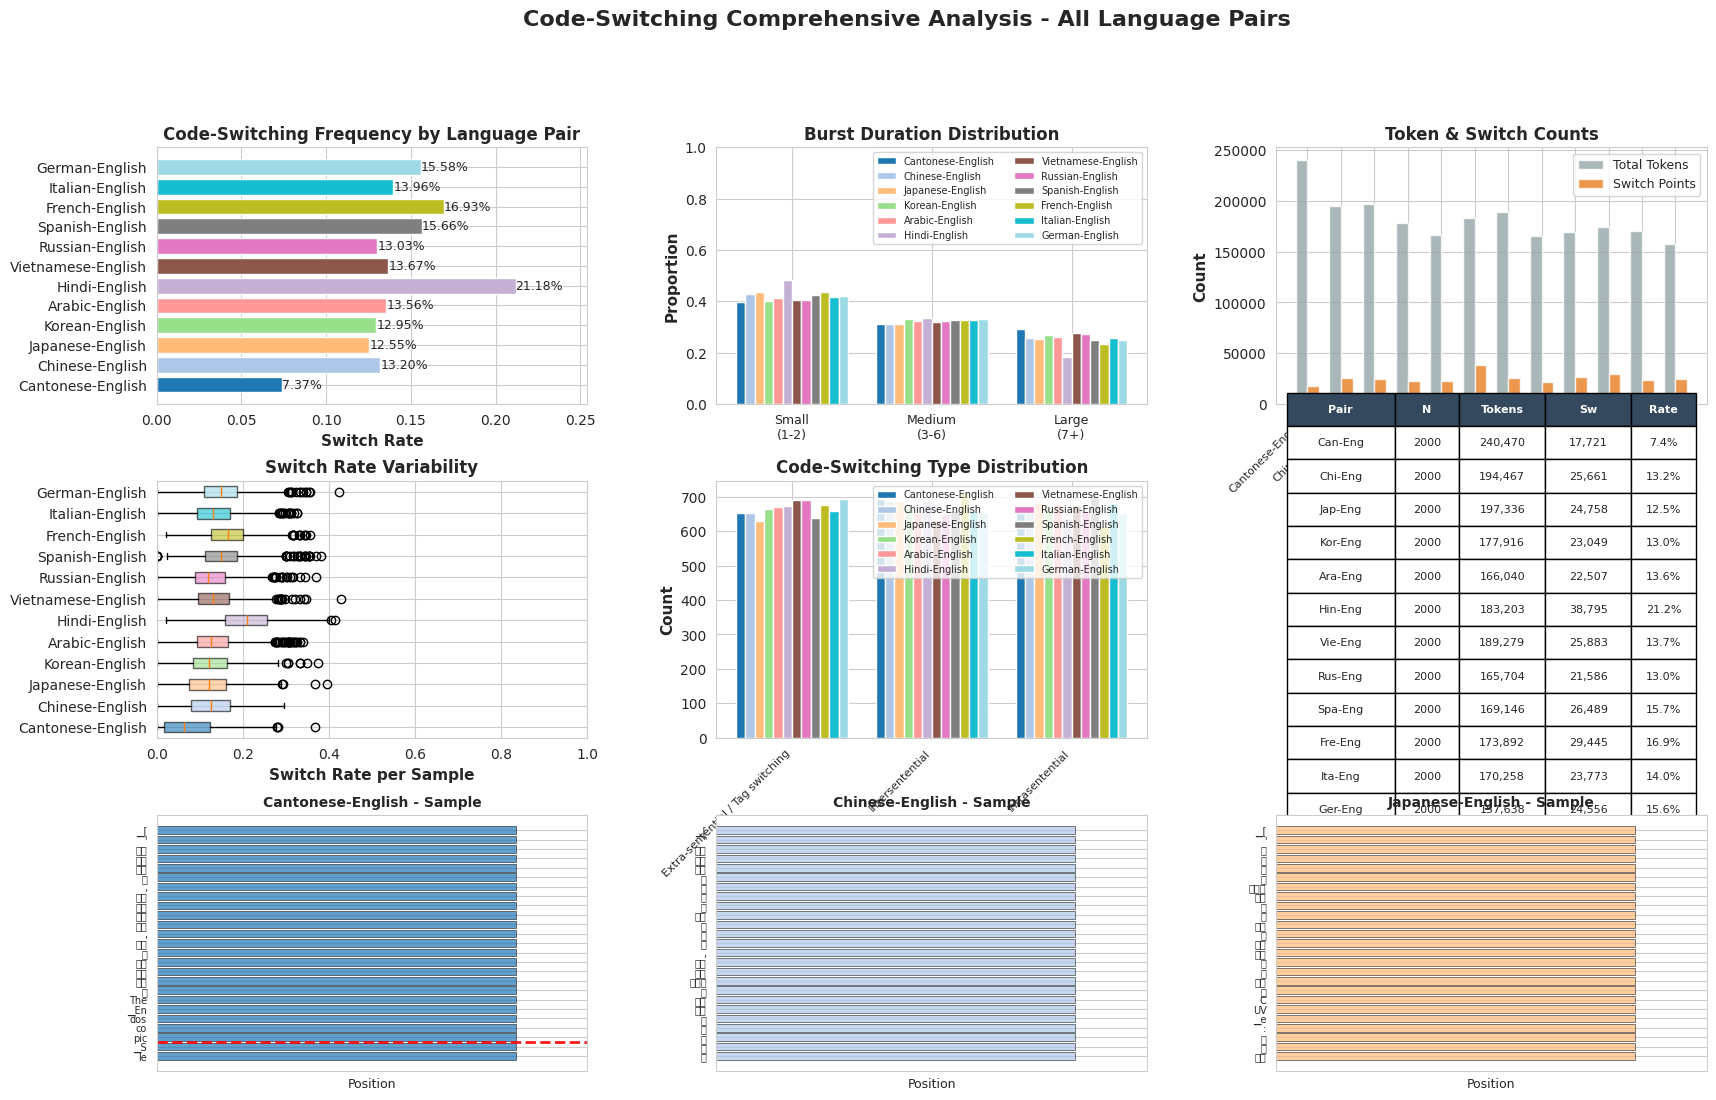


✓ Visualization saved: all_language_pairs_analysis.png


In [ ]:
# ===== Cell 7: 综合可视化 =====
def create_comprehensive_visualization(all_stats: Dict):
    """创建综合统计可视化"""

    n_pairs = len(all_stats)
    if n_pairs == 0:
        print("No data to visualize")
        return

    # 设置样式
    sns.set_style("whitegrid")
    plt.rcParams['figure.facecolor'] = 'white'

    fig = plt.figure(figsize=(20, 12))
    gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

    pairs = list(all_stats.keys())
    colors = plt.cm.tab20(np.linspace(0, 1, n_pairs))

    # 1. Switch Rate对比
    ax = fig.add_subplot(gs[0, 0])
    switch_rates = []
    for s in all_stats.values():
        rate = s['total_switches'] / s['total_tokens'] if s['total_tokens'] > 0 else 0
        switch_rates.append(rate)

    bars = ax.barh(pairs, switch_rates, color=colors)
    ax.set_xlabel('Switch Rate', fontsize=11, fontweight='bold')
    ax.set_title('Code-Switching Frequency by Language Pair', fontsize=12, fontweight='bold')
    ax.set_xlim(0, max(switch_rates) * 1.2 if switch_rates else 0.1)

    # 添加数值标签
    for bar, rate in zip(bars, switch_rates):
        width = bar.get_width()
        ax.text(width, bar.get_y() + bar.get_height()/2.,
                f'{rate:.2%}', ha='left', va='center', fontsize=9)

    # 2. Duration分布
    ax = fig.add_subplot(gs[0, 1])
    duration_names = ['Small\n(1-2)', 'Medium\n(3-6)', 'Large\n(7+)']
    x = np.arange(len(duration_names))
    width = 0.8 / n_pairs

    for i, (pair_name, s) in enumerate(all_stats.items()):
        dist = s['duration_distribution']
        total = sum(dist.values()) or 1
        proportions = [dist[j] / total for j in range(3)]
        ax.bar(x + i * width, proportions, width, label=pair_name, color=colors[i])

    ax.set_ylabel('Proportion', fontsize=11, fontweight='bold')
    ax.set_title('Burst Duration Distribution', fontsize=12, fontweight='bold')
    ax.set_xticks(x + width * (n_pairs - 1) / 2)
    ax.set_xticklabels(duration_names, fontsize=9)
    ax.legend(fontsize=7, ncol=2)
    ax.set_ylim(0, 1)

    # 3. Token统计
    ax = fig.add_subplot(gs[0, 2])
    token_counts = [s['total_tokens'] for s in all_stats.values()]
    switch_counts = [s['total_switches'] for s in all_stats.values()]

    x_pos = np.arange(len(pairs))
    width = 0.35

    ax.bar(x_pos - width/2, token_counts, width, label='Total Tokens', color='#95a5a6', alpha=0.8)
    ax.bar(x_pos + width/2, switch_counts, width, label='Switch Points', color='#e67e22', alpha=0.8)

    ax.set_ylabel('Count', fontsize=11, fontweight='bold')
    ax.set_title('Token & Switch Counts', fontsize=12, fontweight='bold')
    ax.set_xticks(x_pos)
    ax.set_xticklabels(pairs, rotation=45, ha='right', fontsize=8)
    ax.legend(fontsize=9)

    # 4. Switch Rate Box Plot
    ax = fig.add_subplot(gs[1, 0])
    switch_rate_data = [s['switch_rate_per_sample'] for s in all_stats.values() if s['switch_rate_per_sample']]

    if switch_rate_data:
        bp = ax.boxplot(switch_rate_data, labels=pairs, patch_artist=True, vert=False)
        for patch, color in zip(bp['boxes'], colors):
            patch.set_facecolor(color)
            patch.set_alpha(0.6)

    ax.set_xlabel('Switch Rate per Sample', fontsize=11, fontweight='bold')
    ax.set_title('Switch Rate Variability', fontsize=12, fontweight='bold')
    ax.set_xlim(0, 1)

    # 5. CS Type Distribution
    ax = fig.add_subplot(gs[1, 1])
    cs_types_all = set()
    for s in all_stats.values():
        cs_types_all.update(s['cs_type_distribution'].keys())

    cs_types = sorted(list(cs_types_all))[:6]  # 只显示前6种
    x = np.arange(len(cs_types))
    width = 0.8 / n_pairs

    for i, (pair_name, s) in enumerate(all_stats.items()):
        counts = [s['cs_type_distribution'].get(ct, 0) for ct in cs_types]
        ax.bar(x + i * width, counts, width, label=pair_name, color=colors[i])

    ax.set_ylabel('Count', fontsize=11, fontweight='bold')
    ax.set_title('Code-Switching Type Distribution', fontsize=12, fontweight='bold')
    ax.set_xticks(x + width * (n_pairs - 1) / 2)
    ax.set_xticklabels(cs_types, rotation=45, ha='right', fontsize=8)
    ax.legend(fontsize=7, ncol=2)

    # 6. 统计表格
    ax = fig.add_subplot(gs[1, 2])
    ax.axis('off')

    table_data = []
    for s in all_stats.values():
        switch_rate = s['total_switches'] / s['total_tokens'] if s['total_tokens'] > 0 else 0
        table_data.append([
            s['lang_pair'].split('-')[0][:3] + '-' + s['lang_pair'].split('-')[1][:3],
            f"{s['total_samples']}",
            f"{s['total_tokens']:,}",
            f"{s['total_switches']:,}",
            f"{switch_rate:.1%}",
        ])

    table = ax.table(
        cellText=table_data,
        colLabels=['Pair', 'N', 'Tokens', 'Sw', 'Rate'],
        cellLoc='center',
        loc='center',
        colWidths=[0.25, 0.15, 0.2, 0.2, 0.15]
    )
    table.auto_set_font_size(False)
    table.set_fontsize(8)
    table.scale(1, 2)

    for i in range(5):
        table[(0, i)].set_facecolor('#34495e')
        table[(0, i)].set_text_props(weight='bold', color='white')

    # 7-9. 样本可视化
    sample_pairs = list(all_stats.items())[:3]  # 显示前3个语言对

    for idx, (pair_name, s) in enumerate(sample_pairs):
        if not s['processed_samples']:
            continue

        ax = fig.add_subplot(gs[2, idx])

        sample = s['processed_samples'][0]
        tokens = sample['tokens'][:25]
        token_lids = sample['token_lids'][:25]
        y_switch = sample['y_switch'][:25]

        # 绘制token序列
        y_pos = np.arange(len(tokens))
        colors_vis = [colors[idx] if lid != 'neutral' else '#ecf0f1' for lid in token_lids]

        ax.barh(y_pos, [1]*len(tokens), color=colors_vis, alpha=0.7, edgecolor='black', linewidth=0.5)

        # 标记switch points
        for i, is_switch in enumerate(y_switch):
            if is_switch:
                ax.axhline(y=i+0.5, color='red', linestyle='--', linewidth=2, alpha=0.9)

        ax.set_yticks(y_pos)
        ax.set_yticklabels([t[:8] + '..' if len(t) > 8 else t for t in tokens], fontsize=7)
        ax.set_xlabel('Position', fontsize=9)
        ax.set_title(f'{pair_name} - Sample', fontsize=10, fontweight='bold')
        ax.invert_yaxis()
        ax.set_xlim(0, 1.2)
        ax.set_xticks([])

    plt.suptitle('Code-Switching Comprehensive Analysis - All Language Pairs',
                 fontsize=16, fontweight='bold', y=0.995)

    plt.savefig('all_language_pairs_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()

    print("\n✓ Visualization saved: all_language_pairs_analysis.png")


# 生成可视化
create_comprehensive_visualization(all_stats)

In [ ]:

# ===== Cell 8: 导出统计摘要 =====
def export_statistics_summary(all_stats: Dict):
    """导出统计摘要到CSV和文本"""

    # 创建DataFrame
    summary_data = []

    for pair_name, s in all_stats.items():
        switch_rate = s['total_switches'] / s['total_tokens'] if s['total_tokens'] > 0 else 0

        # Duration分布
        dur_dist = s['duration_distribution']
        total_dur = sum(dur_dist.values()) or 1

        summary_data.append({
            'Language_Pair': pair_name,
            'Samples': s['total_samples'],
            'Total_Tokens': s['total_tokens'],
            'Total_Switches': s['total_switches'],
            'Switch_Rate': f"{switch_rate:.4f}",
            'Small_Duration_%': f"{dur_dist[0]/total_dur*100:.1f}",
            'Medium_Duration_%': f"{dur_dist[1]/total_dur*100:.1f}",
            'Large_Duration_%': f"{dur_dist[2]/total_dur*100:.1f}",
            'Mean_Sample_Switch_Rate': f"{np.mean(s['switch_rate_per_sample']):.4f}" if s['switch_rate_per_sample'] else "N/A",
            'Std_Sample_Switch_Rate': f"{np.std(s['switch_rate_per_sample']):.4f}" if s['switch_rate_per_sample'] else "N/A",
        })

    df = pd.DataFrame(summary_data)

    # 保存CSV
    df.to_csv('code_switching_statistics.csv', index=False)
    print("✓ Statistics exported to: code_switching_statistics.csv")

    # 打印摘要
    print("\n" + "="*80)
    print("STATISTICS SUMMARY")
    print("="*80)
    print(df.to_string(index=False))
    print("="*80)

    return df

summary_df = export_statistics_summary(all_stats)


In [ ]:
# ===== Cell 9: 查看特定样本 =====
def show_detailed_sample(pair_key: str, sample_idx: int = 0):
    """展示特定样本的详细信息"""
    if pair_key not in all_stats:
        print(f"Language pair '{pair_key}' not found")
        print(f"Available pairs: {list(all_stats.keys())}")
        return

    samples = all_stats[pair_key]['processed_samples']
    if sample_idx >= len(samples):
        print(f"Sample index {sample_idx} out of range (max: {len(samples)-1})")
        return

    sample = samples[sample_idx]

    print(f"\n{'='*80}")
    print(f"{pair_key} - Sample {sample_idx + 1}")
    print(f"{'='*80}")
    print(f"Original text:\n{sample['text'][:200]}...")
    print(f"\nCS Type: {sample['cs_type']}")
    print(f"CS Function: {sample['cs_function']}")

    print(f"\n{'Idx':<5} {'Token':<18} {'LID':<15} {'Sw':<5} {'Dur':<5} {'Note'}")
    print("-" * 80)

    for i in range(min(30, len(sample['tokens']))):
        token = sample['tokens'][i]
        lid = sample['token_lids'][i]
        sw = sample['y_switch'][i] if i < len(sample['y_switch']) else '-'
        dur = sample['y_duration'][i] if i < len(sample['y_duration']) else '-'

        note = ""
        if sw == 1:
            note = "← SWITCH!"
            if dur == 0:
                note += " [Small]"
            elif dur == 1:
                note += " [Medium]"
            elif dur == 2:
                note += " [Large]"

        print(f"[{i:2d}]  {token:<18} {lid:<15} {sw:<5} {dur:<5} {note}")

    print(f"\n{'='*80}\n")

# 查看几个样本
if len(all_stats) > 0:
    print("\n" + "="*80)
    print("SAMPLE INSPECTION")
    print("="*80)

    for pair_key in list(all_stats.keys())[:3]:  # 查看前3个语言对的样本
        show_detailed_sample(pair_key, 0)


In [ ]:
# ===== Cell 10: 保存处理结果 =====
import pickle

# 保存所有统计数据
with open('all_language_pairs_stats.pkl', 'wb') as f:
    pickle.dump(all_stats, f)

print("✓ All statistics saved to: all_language_pairs_stats.pkl")
print("\n" + "="*80)
print("ALL PROCESSING COMPLETED!")
print("="*80)
print(f"\nTotal language pairs processed: {len(all_stats)}")
print(f"Total samples processed: {sum(s['total_samples'] for s in all_stats.values())}")
print(f"Total tokens analyzed: {sum(s['total_tokens'] for s in all_stats.values()):,}")
print(f"Total switches detected: {sum(s['total_switches'] for s in all_stats.values()):,}")

In [ ]:
# ===== 实际测试 =====
from transformers import AutoTokenizer

xlm_tokenizer = AutoTokenizer.from_pretrained('xlm-roberta-base')
mbert_tokenizer = AutoTokenizer.from_pretrained('bert-base-multilingual-cased')

test_cases = [
    "restaurant",  # 英语/法语同形
    "café",        # 法语借词
    "naïve",       # 法语借词
    "résumé",      # 法语借词
]

print("XLM-RoBERTa tokenization:")
for word in test_cases:
    tokens = xlm_tokenizer.tokenize(word)
    print(f"  {word:12s} → {tokens}")

print("\nmBERT tokenization:")
for word in test_cases:
    tokens = mbert_tokenizer.tokenize(word)
    print(f"  {word:12s} → {tokens}")

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

XLM-RoBERTa tokenization:
  restaurant   → ['▁restaurant']
  café         → ['▁café']
  naïve        → ['▁na', 'ï', 've']
  résumé       → ['▁résumé']

mBERT tokenization:
  restaurant   → ['restaurant']
  café         → ['café']
  naïve        → ['na', '##ï', '##ve']
  résumé       → ['r', '##és', '##um', '##é']


In [ ]:

from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

# 你正在使用的模型
MODEL_NAME = "papluca/xlm-roberta-base-language-detection"

print("="*80)
print(f"Model: {MODEL_NAME}")
print("="*80)

# 加载模型配置
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME)
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

# 获取支持的语言列表
config = model.config
label_names = list(config.id2label.values())

print(f"\nSupported Languages: {len(label_names)}")
print("-"*80)
# 创建语言代码到全名的映射
language_map = {
    'ar': 'Arabic (العربية)',
    'bg': 'Bulgarian (Български)',
    'de': 'German (Deutsch)',
    'el': 'Greek (Ελληνικά)',
    'en': 'English',
    'es': 'Spanish (Español)',
    'fr': 'French (Français)',
    'hi': 'Hindi (हिन्दी)',
    'it': 'Italian (Italiano)',
    'ja': 'Japanese (日本語)',
    'nl': 'Dutch (Nederlands)',
    'pl': 'Polish (Polski)',
    'pt': 'Portuguese (Português)',
    'ru': 'Russian (Русский)',
    'sw': 'Swahili (Kiswahili)',
    'th': 'Thai (ไทย)',
    'tr': 'Turkish (Türkçe)',
    'ur': 'Urdu (اردو)',
    'vi': 'Vietnamese (Tiếng Việt)',
    'zh': 'Chinese (中文)',
}

print(f"{'#':<5} {'Code':<8} {'Language'}")
print("-"*80)

for i, label in enumerate(label_names, 1):
    full_name = language_map.get(label, label)
    print(f"{i:<5} {label:<8} {full_name}")

print("\n" + "="*80)

Model: papluca/xlm-roberta-base-language-detection

Supported Languages: 20
--------------------------------------------------------------------------------
#     Code     Language
--------------------------------------------------------------------------------
1     ja       Japanese (日本語)
2     nl       Dutch (Nederlands)
3     ar       Arabic (العربية)
4     pl       Polish (Polski)
5     de       German (Deutsch)
6     it       Italian (Italiano)
7     pt       Portuguese (Português)
8     tr       Turkish (Türkçe)
9     es       Spanish (Español)
10    hi       Hindi (हिन्दी)
11    el       Greek (Ελληνικά)
12    ur       Urdu (اردو)
13    bg       Bulgarian (Български)
14    en       English
15    fr       French (Français)
16    zh       Chinese (中文)
17    ru       Russian (Русский)
18    th       Thai (ไทย)
19    sw       Swahili (Kiswahili)
20    vi       Vietnamese (Tiếng Việt)



In [6]:
from google.colab import userdata

# 将 token 存在 Colab Secrets 中
token = userdata.get('GITHUB_TOKEN')

!git clone https://{token}@github.com/Eugenia-Z/CodeSwitch.git

!git add .
!git commit -m "Add transformer-based LID"
!git push

fatal: destination path 'CodeSwitch' already exists and is not an empty directory.
fatal: not a git repository (or any of the parent directories): .git
fatal: not a git repository (or any of the parent directories): .git
fatal: not a git repository (or any of the parent directories): .git


fatal: not a git repository (or any of the parent directories): .git
